In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
data = pd.read_csv('synthetic_data_lung_cancer.csv')
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SUBJECT_ID,560971.0,478.783759,274.017435,1.000000,242.000000,471.000000,701.00000,984.000000
TIME,560971.0,4.160220,2.372683,0.000001,2.166878,4.220659,6.15983,16.866712


In [2]:
sample_definition_ids = data['DEFINITION_ID'].drop_duplicates().sample(50, random_state=1)
sample_definition_ids.tolist()

['procedure_235',
 'observation_151',
 'condition_1203',
 'measurement_1024',
 'condition_2200',
 'condition_1057',
 'condition_1870',
 'condition_915',
 'procedure_462',
 'measurement_1220',
 'observation_162',
 'condition_204',
 'drug_379',
 'measurement_1160',
 'measurement_1005',
 'condition_1231',
 'condition_840',
 'measurement_1159',
 'observation_122',
 'measurement_411',
 'condition_744',
 'condition_1462',
 'measurement_90',
 'condition_455',
 'condition_2179',
 'measurement_478',
 'measurement_64',
 'observation_32',
 'observation_7',
 'condition_359',
 'condition_2184',
 'condition_322',
 'procedure_372',
 'condition_2291',
 'procedure_254',
 'measurement_667',
 'condition_1052',
 'procedure_137',
 'measurement_896',
 'drug_156',
 'procedure_404',
 'measurement_1034',
 'measurement_962',
 'condition_1966',
 'condition_623',
 'condition_1885',
 'drug_277',
 'procedure_84',
 'condition_1815',
 'condition_2345']

In [3]:
data['CATEGORY'] = data['DEFINITION_ID'].apply(lambda x: x.split('_')[0])
category_counts = data.groupby(['SUBJECT_ID', 'CATEGORY']).size().unstack(fill_value=0)
category_counts.head()

CATEGORY,condition,death,drug,measurement,observation,procedure
SUBJECT_ID,,,,,,
1,261,0,195,33,48,38
2,95,1,45,88,78,57
3,144,0,59,561,69,95
4,30,1,11,385,22,50
6,30,0,8,131,34,26


In [4]:
time_to_event = data.groupby('SUBJECT_ID')['TIME'].max()
cox_data = category_counts.merge(time_to_event, on='SUBJECT_ID')
cox_data['event'] = (cox_data['death'] > 0).astype(int)
cox_data.drop(columns=["death"], inplace=True)
cox_data.head()

,condition,drug,measurement,observation,procedure,TIME,event
SUBJECT_ID,,,,,,,
1,261,195,33,48,38,4.932455,0
2,95,45,88,78,57,2.518113,1
3,144,59,561,69,95,3.994337,0
4,30,11,385,22,50,4.002734,1
6,30,8,131,34,26,5.894177,0


In [5]:
pip install lifelines

Note: you may need to restart the kernel to use updated packages.


In [6]:
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='TIME', event_col='event')
cox_model_summary = cox_model.summary
cox_model.summary


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
condition,0.004508,1.004518,0.001907,0.000771,0.008245,1.000771,1.008280,0.0,2.364195,1.806929e-02,5.790317
drug,-0.006004,0.994014,0.002804,-0.011499,-0.000509,0.988566,0.999491,0.0,-2.141628,3.222341e-02,4.955747
measurement,-0.003044,0.996961,0.000541,-0.004104,-0.001983,0.995904,0.998019,0.0,-5.625310,1.851749e-08,25.686536
observation,-0.012518,0.987560,0.002761,-0.017929,-0.007107,0.982230,0.992918,0.0,-4.534143,5.783777e-06,17.399557
procedure,-0.002372,0.997631,0.003959,-0.010132,0.005388,0.989919,1.005403,0.0,-0.599070,5.491265e-01,0.864789


In [7]:
# Assuming cox_model is your trained CoxPHFitter model
# and cox_data is your dataset

# Calculate risk scores
cox_data['risk_scores'] = cox_model.predict_partial_hazard(cox_data)

# Define the time point for prediction (e.g., 1 year)
prediction_time = 1

# Predict the survival probability at the specified time point
predicted_survival = cox_model.predict_survival_function(cox_data, times=[prediction_time])

# The survival probability at the specified time point
predicted_survival_at_1_year = predicted_survival.T[prediction_time]

# The 1-year mortality probability (probability of death within 1 year)
mortality_probability_at_1_year = 1 - predicted_survival_at_1_year

# Add the calculated probabilities to your dataset if needed
cox_data['1_year_mortality_probability'] = mortality_probability_at_1_year

Asked GPT 4 to do it, I literally don't have any idea for this step

In [8]:
cox_data

,condition,drug,measurement,observation,procedure,TIME,event,risk_scores,1_year_mortality_probability
SUBJECT_ID,,,,,,,,,
1,261,195,33,48,38,4.932455,0,3.982037,0.001304
2,95,45,88,78,57,2.518113,1,2.575569,0.000843
3,144,59,561,69,95,3.994337,0,0.715811,0.000234
4,30,11,385,22,50,4.002734,1,1.955731,0.000640
6,30,8,131,34,26,5.894177,0,3.930013,0.001287
...,...,...,...,...,...,...,...,...,...
975,13,0,22,6,9,0.288566,0,7.866851,0.002574
976,11,0,63,14,29,0.273975,0,5.937313,0.001943
979,2,0,62,1,0,0.094755,0,7.208420,0.002359


In [9]:
# Assuming you have risk scores in 'risk_scores' and 1-year mortality probabilities in '1_year_mortality_probability'
cox_data['risk_scores'] = cox_model.predict_partial_hazard(cox_data)
features = pd.concat([cox_data['risk_scores'], cox_data['1_year_mortality_probability']], axis=1)
target=cox_data['event']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.72
Precision: 0.53
Recall: 0.47
F1-score: 0.49


ROC AUC Score: 0.75


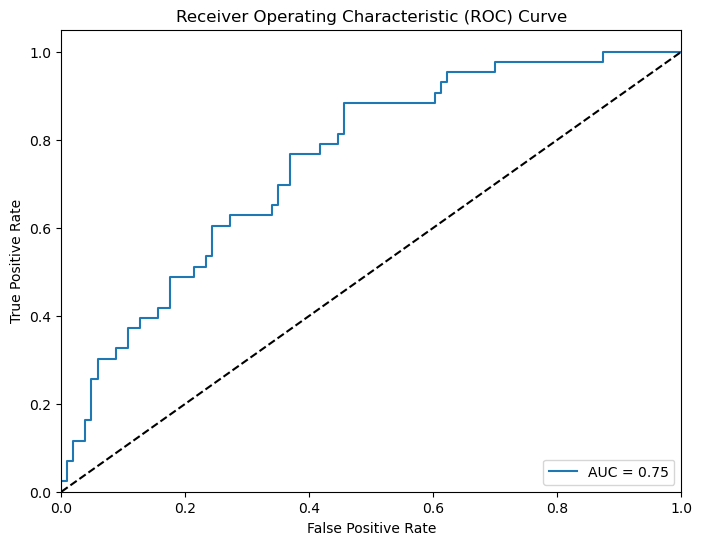

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [11]:
cox_data

,condition,drug,measurement,observation,procedure,TIME,event,risk_scores,1_year_mortality_probability
SUBJECT_ID,,,,,,,,,
1,261,195,33,48,38,4.932455,0,3.982037,0.001304
2,95,45,88,78,57,2.518113,1,2.575569,0.000843
3,144,59,561,69,95,3.994337,0,0.715811,0.000234
4,30,11,385,22,50,4.002734,1,1.955731,0.000640
6,30,8,131,34,26,5.894177,0,3.930013,0.001287
...,...,...,...,...,...,...,...,...,...
975,13,0,22,6,9,0.288566,0,7.866851,0.002574
976,11,0,63,14,29,0.273975,0,5.937313,0.001943
979,2,0,62,1,0,0.094755,0,7.208420,0.002359


In [12]:
from lifelines.utils import concordance_index
c_index = concordance_index(cox_data['1_year_mortality_probability'], cox_data['risk_scores'], cox_data['TIME'])
print(f"Concordance index: {c_index}")

Concordance index: 1.0


In [13]:
from sksurv.metrics import concordance_index_censored
time_point = 1
event_observed = cox_data['event'].astype(bool)
times = cox_data['TIME']
risk_scores = cox_model.predict_partial_hazard(cox_data)
result = concordance_index_censored(event_observed, times, risk_scores)
time_auc = result[0]
print(f"Time-dependent AUC at 1 year: {time_auc}")


Time-dependent AUC at 1 year: 0.8473339870164999


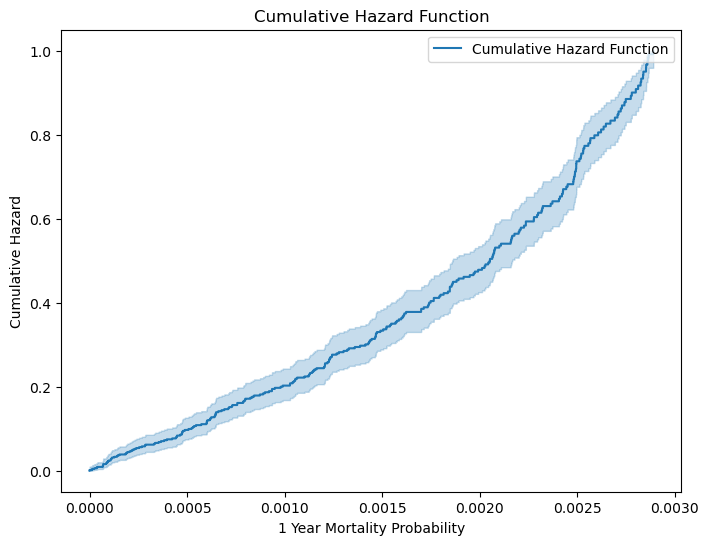

In [14]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(cox_data['1_year_mortality_probability'], event_observed=event_observed)
plt.figure(figsize=(8, 6))
kmf.plot_cumulative_density(label="Cumulative Hazard Function")
plt.xlabel("1 Year Mortality Probability")
plt.ylabel("Cumulative Hazard")
plt.title("Cumulative Hazard Function")
plt.legend(loc="upper right")
plt.show()


The line represents the cumulative hazard estimate, and the shaded area around I think it represents a confidence interval or standard error( it means the uncertainty around the estimate)

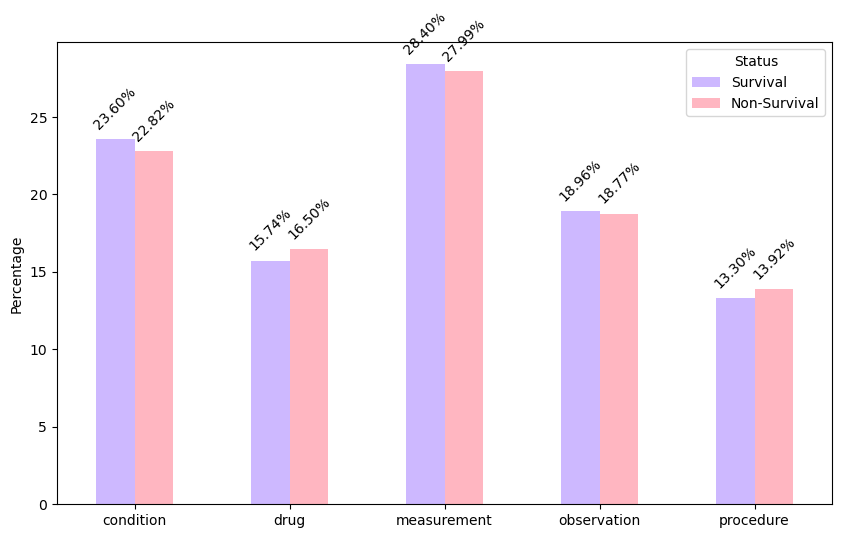

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'event': [0, 1],
    'condition': [300, 141],
    'drug': [200, 102],
    'measurement': [361, 173],
    'observation': [241, 116],
    'procedure': [169, 86]
}

df = pd.DataFrame(data)

survival_counts = df.loc[0, ['condition', 'drug', 'measurement', 'observation', 'procedure']].values
non_survival_counts = df.loc[1, ['condition', 'drug', 'measurement', 'observation', 'procedure']].values

survival_percentage = (survival_counts / sum(survival_counts)) * 100
non_survival_percentage = (non_survival_counts / sum(non_survival_counts)) * 100

df_percentage = pd.DataFrame({
    'Survival': survival_percentage,
    'Non-Survival': non_survival_percentage
}, index=['condition', 'drug', 'measurement', 'observation', 'procedure'])

ax = df_percentage.plot(kind='bar', figsize=(10, 6), color=['#CDB8FF', '#FFB6C1'])
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=10, color='black', padding=5, rotation=45)  # 旋转45度

plt.ylabel("Percentage")
plt.legend(title="Status", loc="upper right")
plt.xticks(rotation=0)

plt.show()
